# Analysis of LSOA results

## Proportions of stroke types: Analysis of SAMueL data

Data from SAMueL using NIHSS 11+ as a surrogate for LVO:

| Admission type                       | All arrivals | Arrival within 6 hrs known onset | Arrival within 4 hrs known onset |
|--------------------------------------|--------------|----------------------------------|----------------------------------|
| Proportion all admissions            | 100          | 42.9                             | 37.1                             |
| Proportion haemorrhagic              | 11.5         | 13.6                             | 14.1                             |
| Proportion ischaemic                 | 88.5         | 86.4                             | 85.9                             |
| Proportion ischaemic with NIHSS 0-10 | 74.9         | 67.4                             | 65.7                             |
| Proportion ischaemic with NIHSS 11+  | 25.1         | 32.6                             | 34.3                             |

For original analysis see: https://samuel-book.github.io/samuel-1/descriptive_stats/10_using_nihss_10_for_lvo.html

## Set analysis parameters

In [1]:
file_name = 'lsoa_base'
limit_to_england = True

stroke_type_propotions = {
    'haemorragic': 0.136,
    'lvo': 0.33 * (1 - 0.136),
    'nlvo': 0.67 * (1 - 0.136)}

In [2]:
target_ivt = 0.2
target_mt = 0.1
prop_mt_previously_receiving_ivt = 0.85

prop_lvo_receiving_mt = target_mt / stroke_type_propotions['lvo']
print(f'{prop_lvo_receiving_mt:0.3f}')

0.351


In [3]:
prop_lvo_receiving_ivt = prop_lvo_receiving_mt * prop_mt_previously_receiving_ivt
print(f'{prop_lvo_receiving_ivt:0.3f}')

0.298


In [4]:
prop_nlvo_receiving_ivt = (
    (target_ivt - (prop_lvo_receiving_ivt * stroke_type_propotions['lvo'])) / 
    stroke_type_propotions['nlvo'])

print(f'{prop_nlvo_receiving_ivt:0.3f}')

0.199


In [5]:
# Check sums
prop_all_receiving_ivt = (
    (stroke_type_propotions['nlvo'] * prop_nlvo_receiving_ivt) +
    (stroke_type_propotions['lvo'] * prop_lvo_receiving_ivt))

print(f'{prop_all_receiving_ivt:0.3f}')

0.200


## Import packages

In [6]:
import contextily as ctx
import geopandas
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_rows', 150)

## Load data

### Load shape file

In [7]:
filename = "zip://./data/Lower_layer_super_output_areas_(E+W)_2011_Boundaries_(Generalised_Clipped)_V2.zip"
lsoa_gdf = geopandas.read_file(filename, crs='EPSG:27700')
lsoa_gdf.head()

,LSOA11CD,LSOA11NM,LSOA11NMW,geometry
0,E01000001,City of London 001A,City of London 001A,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,City of London 001B,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,City of London 001C,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,City of London 001E,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,"POLYGON ((545122.049 184314.931, 545271.917 18..."


### Load hospital info

In [8]:
hospitals_gdf = geopandas.read_file('./data/stroke_hospitals_2022.csv')
hospitals_gdf.geometry = geopandas.points_from_xy(
        hospitals_gdf.Easting, hospitals_gdf.Northing)
# Set crs for geometry, using epsg4326 for lat/long
hospitals_gdf = hospitals_gdf.set_crs(epsg=27700)

if limit_to_england:
    mask = hospitals_gdf['Country'] ==  'England'
    hospitals_gdf = hospitals_gdf[mask]
hospitals_gdf.head()


,Postcode,Hospital_name,Use_IVT,Use_MT,Use_MSU,Country,Strategic Clinical Network,Health Board / Trust,Stroke Team,SSNAP name,Admissions 21/22,Thrombolysis,ivt_rate,Easting,Northing,Neuroscience,30 England Thrombectomy Example,hospital_city,Notes,geometry
0,RM70AG,RM70AG,1,1,1,England,London SCN,Barking,Havering and Redbridge University Hospitals N...,Queens Hospital Romford HASU,981,117,11.9,551118,187780,1,0,Romford,,POINT (551118.000 187780.000)
1,E11BB,E11BB,1,1,1,England,London SCN,Barts Health NHS Trust,The Royal London Hospital,Royal London Hospital HASU,861,115,13.4,534829,181798,1,1,Royal London,,POINT (534829.000 181798.000)
2,SW66SX,SW66SX,1,1,1,England,London SCN,Imperial College Healthcare NHS Trust,"Charing Cross Hospital, London",Charing Cross Hospital HASU,1147,113,9.9,524226,176487,1,1,Charing Cross,,POINT (524226.000 176487.000)
3,SE59RW,SE59RW,1,1,1,England,London SCN,King's College Hospital NHS Foundation Trust,"King's College Hospital, London",King's College Hospital HASU,824,124,15,532536,176228,1,0,Kings College,,POINT (532536.000 176228.000)
4,BR68ND,BR68ND,1,0,0,England,London SCN,King's College Hospital NHS Foundation Trust,Princess Royal University Hospital,Princess Royal University Hospital HASU,847,113,13.3,543443,165032,0,0,Princess Royal,,POINT (543443.000 165032.000)


### Load LSOA model output data

In [9]:
lsoa_data = pd.read_csv(f'./output/{file_name}.csv')
lsoa_data.head(3).T

,0,1,2
lsoa,Adur 001A,Adur 001B,Adur 001C
closest_ivt_unit,BN25BE,BN25BE,BN112DH
closest_ivt_time,17.6,18.7,17.6
closest_mt_unit,BN25BE,BN25BE,BN25BE
closest_mt_time,17.6,18.7,19.8
transfer_mt_unit,BN25BE,BN25BE,BN25BE
transfer_mt_time,0.0,0.0,31.6
mt_transfer_required,False,False,True
msu_unit,BN25BE,BN25BE,BN25BE
msu_time,17.6,18.7,19.8


In [10]:
# Merge with shape file

#lsoa_data_gdf = lsoa_data.merge(lsoa_gdf, left_on='lsoa', right_on='LSOA11NM', how='left')
lsoa_data_gdf = lsoa_gdf.merge(lsoa_data, left_on='LSOA11NM', right_on='lsoa', how='left')
lsoa_data_gdf.head()

,LSOA11CD,LSOA11NM,LSOA11NMW,geometry,lsoa,closest_ivt_unit,closest_ivt_time,closest_mt_unit,closest_mt_time,transfer_mt_unit,...,mothership_lvo_ivt_mean_mRS,mothership_lvo_mt_mean_mRS,mothership_nlvo_ivt_mean_mRS,mothership_lvo_ivt_mean_shift,mothership_lvo_mt_mean_shift,mothership_nlvo_ivt_mean_shift,mothership_lvo_ivt_improved,mothership_lvo_mt_improved,mothership_nlvo_ivt_improved,Admissions_Est_2022
0,E01000001,City of London 001A,City of London 001A,"POLYGON ((532105.092 182011.230, 532162.491 18...",City of London 001A,E11BB,11.2,E11BB,11.2,E11BB,...,3.48,2.77,1.72,-0.16,-0.87,-0.57,0.17,0.76,0.57,2.965686
1,E01000002,City of London 001B,City of London 001B,"POLYGON ((532746.813 181786.891, 532671.688 18...",City of London 001B,E11BB,10.1,E11BB,10.1,E11BB,...,3.48,2.76,1.72,-0.16,-0.88,-0.57,0.17,0.77,0.57,1.318083
2,E01000003,City of London 001C,City of London 001C,"POLYGON ((532135.145 182198.119, 532158.250 18...",City of London 001C,E11BB,12.2,E11BB,12.2,E11BB,...,3.48,2.77,1.72,-0.16,-0.87,-0.57,0.17,0.76,0.57,2.306645
3,E01000005,City of London 001E,City of London 001E,"POLYGON ((533807.946 180767.770, 533649.063 18...",City of London 001E,E11BB,9.0,E11BB,9.0,E11BB,...,3.48,2.76,1.72,-0.16,-0.88,-0.57,0.17,0.77,0.57,0.659041
4,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,"POLYGON ((545122.049 184314.931, 545271.917 18...",Barking and Dagenham 016A,RM70AG,16.5,RM70AG,16.5,RM70AG,...,3.48,2.80,1.72,-0.16,-0.84,-0.57,0.17,0.75,0.57,1.318083


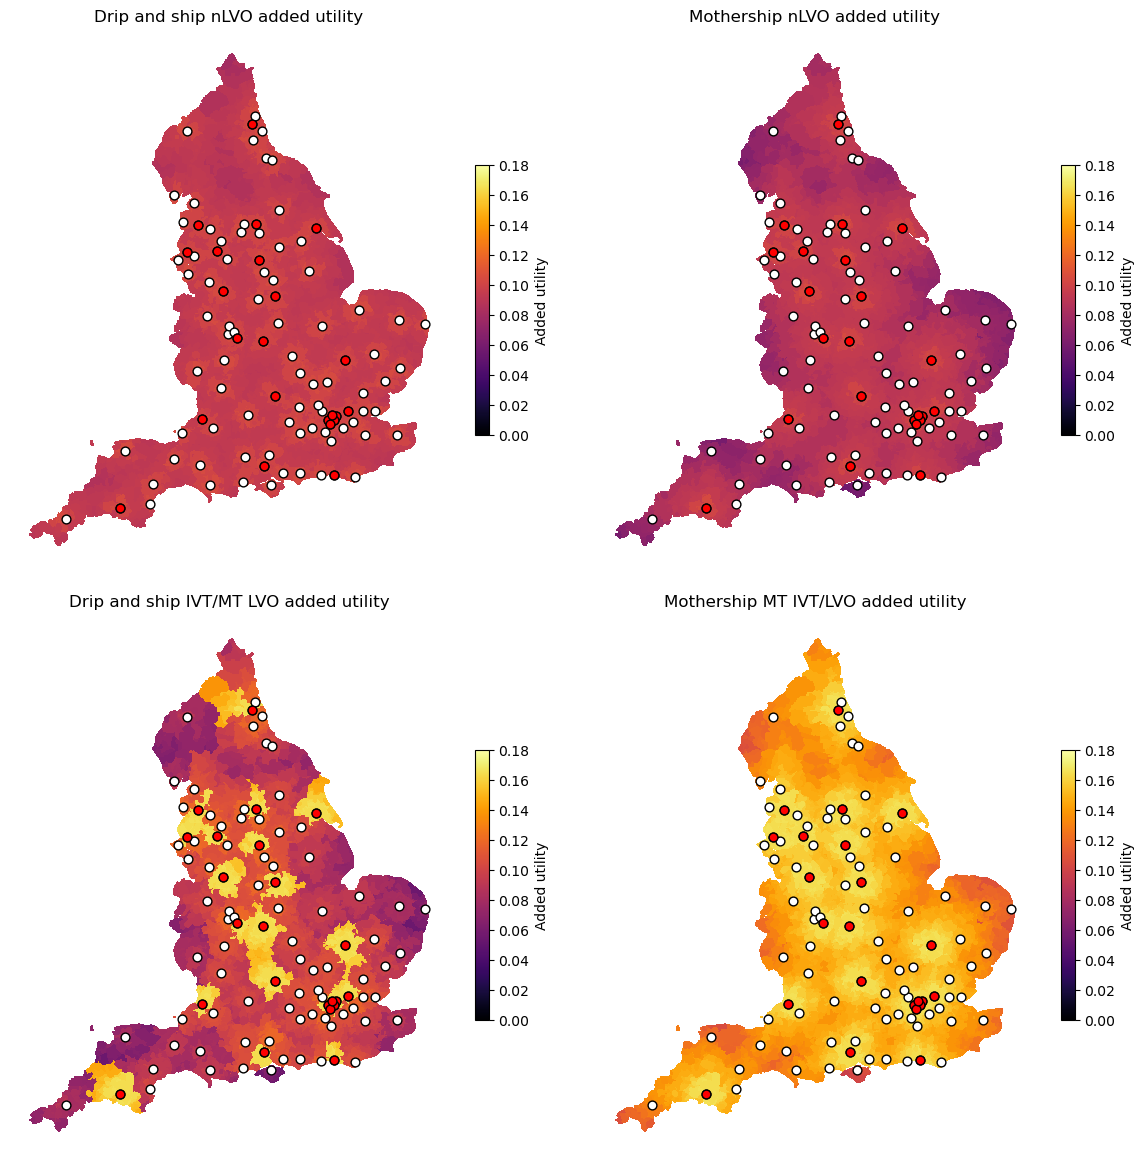

In [11]:
vmax = 0.18

fig = plt.figure(figsize=(12,12))

cols = ['drip_ship_nlvo_ivt_added_utility',
    'mothership_nlvo_ivt_added_utility',
    'drip_ship_lvo_mt_added_utility',
    'mothership_lvo_mt_added_utility']

titles = ['Drip and ship nLVO added utility',
    'Mothership nLVO added utility',
    'Drip and ship IVT/MT LVO added utility',    
    'Mothership MT IVT/LVO added utility']

for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    lsoa_data_gdf.plot(ax=ax, # Set which axes to use for plot (only one here)
                 column=cols[i], # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 vmin=0, # Manual scale min (remove to make automatic)
                 vmax=vmax, # Manual scale max (remove to make automatic)
                 cmap='inferno', # Colour map to use
                 # Adjust size of colourmap key, and add label
                 legend_kwds={'shrink':0.5, 'label':'Added utility'},
                 # Set to display legend
                 legend=True)
    
    # Add hospitals
    mask = hospitals_gdf['Use_IVT'] == '1'
    hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='w', markersize=40, marker='o')
    mask = hospitals_gdf['Use_MT'] == '1'
    hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='r', markersize=40, marker='o')

    ax.set_title(titles[i])
    ax.set_axis_off() # Turn of axis line and numbers
plt.tight_layout(pad=2)
plt.show()

In [12]:
lsoa_data_gdf['nlvo_ivt_added_utility_mothership_minus_dripship'] = \
    lsoa_data_gdf['mothership_nlvo_ivt_added_utility'] - lsoa_data_gdf['drip_ship_nlvo_ivt_added_utility']

lsoa_data_gdf['lvo_ivt_added_utility_mothership_minus_dripship'] = \
    lsoa_data_gdf['mothership_lvo_mt_added_utility'] - lsoa_data_gdf['drip_ship_lvo_mt_added_utility']

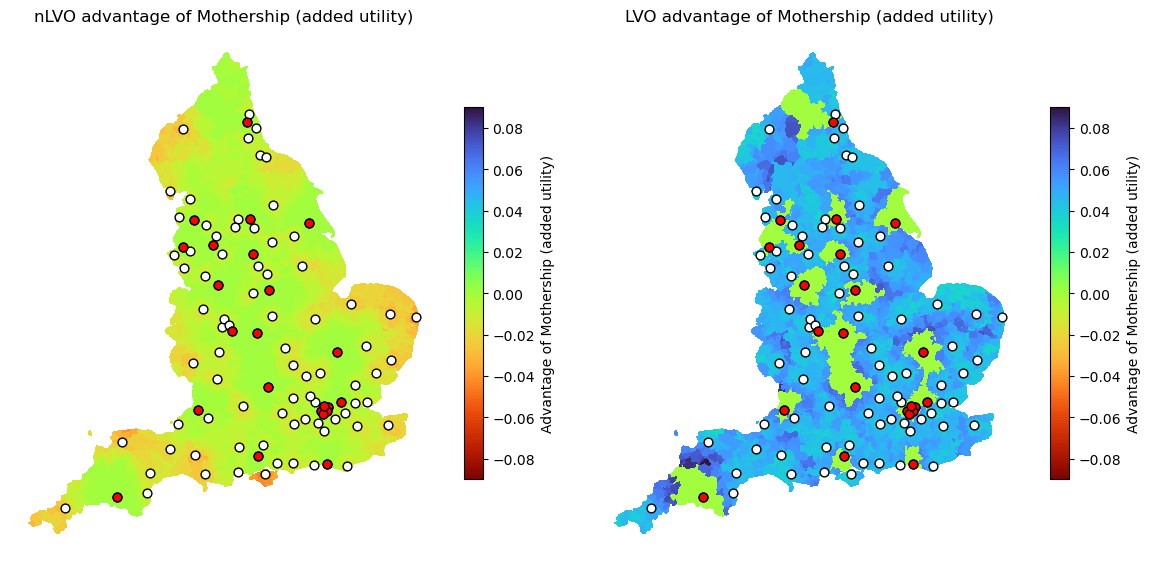

In [13]:
vmin = -0.09
vmax = 0.09

fig = plt.figure(figsize=(12,8))

cols = ['nlvo_ivt_added_utility_mothership_minus_dripship',
    'lvo_ivt_added_utility_mothership_minus_dripship']

titles = ['nLVO advantage of Mothership (added utility)',
          'LVO advantage of Mothership (added utility)']

for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    lsoa_data_gdf.plot(ax=ax, # Set which axes to use for plot (only one here)
                 column=cols[i], # Column to apply colour
                 antialiased=False, # Avoids artifact boundry lines
                 edgecolor='face', # Make LSOA boundry same colour as area
                 vmin=vmin, # Manual scale min (remove to make automatic)
                 vmax=vmax, # Manual scale max (remove to make automatic)
                 cmap='turbo_r', # Colour map to use
                 # Adjust size of colourmap key, and add label
                 legend_kwds={'shrink':0.5, 'label':'Advantage of Mothership (added utility)'},
                 # Set to display legend
                 legend=True)
    
    # Add hospitals
    mask = hospitals_gdf['Use_IVT'] == '1'
    hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='w', markersize=40, marker='o')
    mask = hospitals_gdf['Use_MT'] == '1'
    hospitals_gdf[mask].plot(ax=ax, edgecolor='k', facecolor='r', markersize=40, marker='o')

    ax.set_title(titles[i])
    ax.set_axis_off() # Turn of axis line and numbers
plt.tight_layout(pad=2)
plt.show()